# Implementacja momentu i normalizacji gradientu
## [Zadanie](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org6058800)


Zaimplementować dwa usprawnienia uczenia gradientowego sieci neuronowej:

- moment,
- normalizację gradientu RMSProp.

Porównać szybkość zbieżności procesu uczenia dla obu wariantów.

Przeprowadzić eksperymenty na zbiorach:

- square-large,
- steps-large,
- multimodal-large.

Literatura:

- Uczenie gradientowe z momentem: rozdział 3.2.2 Computational Intelligence, A. P. Engelbrecht
- Normalizacja gradientu: Wykład 6e: http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
import random
import time
import math

# the fixed grain ensures the reproducibility of the results
random.seed(123)

In [2]:
#### Miscellaneous functions
def activation_func(name):
    """
    The activation function.
    """
    if(name == 'linear'):
        return lambda x: x
    elif(name == 'sigmoid'):
        return lambda x: (1 / (1 + np.exp(-x)))
    else:
        print('Unknown activation function - using sigmoid')
        return lambda x: (1 / (1 + np.exp(-x)))
    
def activation_prime(name):
    """
    Derivative of the activation function.
    """
    if(name == 'linear'):
        return lambda x: 1
    elif(name == 'sigmoid'):
        sigmoid = lambda x: (1 / (1 + np.exp(-x))) 
        return lambda x: sigmoid(x) * (1-sigmoid(x)) 
    else:
        print('Unrecognized activation function has been replaced with the default sigmoid ')
        sigmoid = lambda x: (1 / (1 + np.exp(-x)))                           
        return lambda x: sigmoid(x) * (1-sigmoid(x)) 

### Neural network initialization

In [3]:
class MLP:
    def __init__(self, layers, activation_functions, initial_dist = 'default'):
        """
        Presence of at least one hidden layer is an accompanying assumption        

        Takes:        
        layers - list of numbers of neurons in subsequent layers
        activation_functions - list of names of functions ie ('sigmoid', 'linear')
        
        Remarks: 
          - Length of layers list should be equal to length of activation_functions list + 1 
          - The biases and weights for the network are initialized randomly, using continuous uniform 
          distribution with certain bounds between 0 and 1 or -1 and 1 or Gaussian distribution with mean 0, 
          and variance 1.
        """
        
        self.layers = layers
        self.activation_functions = activation_functions
        self.weights = []
        self.biases = []
        
        # Last run info
        self._layerInput = []
        self._layerOnput = []
        self._previousWeightData = []
        
        # Create the weights
        if(initial_dist == 'gaussian'): 
            for i in range(len(layers) - 1):
                self.weights.append(np.random.randn(layers[i+1], layers[i]))
                self.biases.append(np.random.randn(layers[i+1], 1))
                
        elif(initial_dist == 'uniform'): 
            for i in range(len(layers) - 1):
                self.weights.append(np.random.uniform(-1, 1, size=(layers[i+1], layers[i]))) 
                self.biases.append(np.random.uniform(-1, 1, size=(layers[i+1], 1))) 
                
        else:
            print('Unrecognized initial distribution has been replaced with the default uniform distribution bounded with 0 and 1.')
            for i in range(len(layers) - 1):
                self.weights.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i])))
                self.biases.append(np.random.uniform(0, 1, size=(layers[i+1], 1)))
            
    def forward(self, x):
        """
        Returns the output of the network if x is an input.
        """
        
        a = x
        z = []
        activations = [a]
        
        for i in range(len(self.weights)):
            activation_function = activation_func(self.activation_functions[i])
            z.append(self.weights[i].dot(a) + self.biases[i])
            
            a = activation_function(z[-1])
            activations.append(a)
            
        return (z, activations)
                  
    def backprop(self, y, z, activations):
        """
        Function performing backpropagation
        Returns nabla_b and nabla_w representing the
        derivatives by weights and biases respectively. 
        nabla_b and nabla_w are calculated layer-by-layer.
        """ 
        
        nabla_w = [] 
        nabla_b = []

        # deltas for each layer 
        d = [0 for i in range (len(self.weights))]  
                  
        # the last layer error
        d[-1] = ((activations[-1] - y) * (activation_prime(self.activation_functions[-1]))(z[-1])) 
        
        # backward pass
        for i in reversed(range(len(d)-1)):
            d[i] = self.weights[i+1].T.dot(d[i+1]) * (activation_prime(self.activation_functions[i])(z[i]))  
                  
        nabla_b = [d.dot(np.ones((y.shape[1],1))) for d in d]
        nabla_w = [d.dot(activations[i].T) for i,d in enumerate(d)]
                  
        return nabla_w, nabla_b
                  
                  
    def train(self, x, y, batch_size = 10, epochs = 100, eta = 0.01):
        """
        Updates weights and biases based on the output using backpropagation.
        
        The version with the update of the scales after the presentation 
        of all patterns and the version with the update after the presentation
        of subsequent portions (batch) was performed within one function. 
        To get the first variant of operation as batch size the number of all
        observations should be given.
        """
        mae = []
        for epoch in range(epochs):
            res = []
            
            a = np.arange(len(y[0]))
            random.shuffle(a)
            updated_x = np.array([[x[0][i] for i in a]])
            updated_y = np.array([[y[0][i] for i in a]])
            i = 0 
            
            while(i < len(y[0])):
                
                x_batch = updated_x[0][i : (i + batch_size)].reshape(1,-1)
                y_batch = updated_y[0][i : (i + batch_size)].reshape(1,-1)
                i += batch_size
                
                z, activations = self.forward(x_batch)
                nabla_w, nabla_b = self.backprop(y_batch, z, activations)
                
                self.weights = [w - (eta / batch_size) * dw for w, dw in zip(self.weights, nabla_w)]
                # print(self.weights)
                self.biases = [b - (eta / batch_size) * db for b, db in zip(self.biases, nabla_b)]
            
            z, activations = self.forward(x)
            mae.append(metrics.mean_absolute_error(y[0], activations[-1][0]))
            
        return mae, activations
                
                
    def trainWithMomentum(self, x, y, batch_size = 10, epochs = 100, eta = 0.01, lamb = 0.05):
        
        mae = []
        
        for epoch in range(epochs):
            
            a = np.arange(len(y[0]))
            random.shuffle(a)
            updated_x = np.array([[x[0][i] for i in a]])
            updated_y = np.array([[y[0][i] for i in a]])
            
            weight_momentum = [np.zeros(shape = w.shape) for w in self.weights]
            bias_momentum = [np.zeros(shape = b.shape) for b in self.biases]
            
            i = 0
                        
            while(i < len(y[0])):
                
                x_batch = updated_x[0][i : (i + batch_size)].reshape(1,-1)
                y_batch = updated_y[0][i : (i + batch_size)].reshape(1,-1)
                i += batch_size
                
                z, activations = self.forward(x_batch)
                nabla_w, nabla_b = self.backprop(y_batch, z, activations)
                
                weight_momentum = [dw + wm * lamb for dw, wm in zip(nabla_w, weight_momentum)]
                bias_momentum = [db + bm * lamb for db, bm in zip(nabla_b, bias_momentum)]
                                                                
                self.weights = [w - (eta * m)/ batch_size for w, m in zip(self.weights, weight_momentum)]
                self.biases = [b - (eta * m) / batch_size for b, m in zip(self.biases, bias_momentum)]
                
            z, activations = self.forward(x)
            mae.append(metrics.mean_absolute_error(y[0], activations[-1][0]))
            
        return mae, activations
                                
        
    def trainWithRMSProp(self, x, y, batch_size = 10, epochs = 100, eta = 0.1, beta = 0.75, eps = 1e-8):

        mae = []
        
        for epoch in range(epochs):
            
            a = np.arange(len(y[0]))
            random.shuffle(a)
            updated_x = np.array([[x[0][i] for i in a]])
            updated_y = np.array([[y[0][i] for i in a]])
            
            weight_moving_avg = [np.zeros(shape = w.shape) for w in self.weights]
            bias_moving_avg = [np.zeros(shape = b.shape) for b in self.biases]
            
            i = 0
                        
            while(i < len(y[0])):
                
                x_batch = updated_x[0][i : (i + batch_size)].reshape(1,-1)
                y_batch = updated_y[0][i : (i + batch_size)].reshape(1,-1)
                i += batch_size
                
                z, activations = self.forward(x_batch)
                nabla_w, nabla_b = self.backprop(y_batch, z, activations)
                
                # E[g^2]
                weight_moving_avg = [beta * wma + (1 - beta) * dw**2 for dw, wma in zip(nabla_w, weight_moving_avg)]
                bias_moving_avg = [beta * bma + (1 - beta) * db**2 for db, bma in zip(nabla_b, bias_moving_avg)]

                self.weights = [w - (eta * dw/np.sqrt(wma + eps))/ batch_size for w, dw, wma in zip(self.weights, nabla_w, weight_moving_avg)]
                self.biases = [b - (eta * db/np.sqrt(bma + eps))/ batch_size for b, db, bma in zip(self.biases, nabla_b, bias_moving_avg)]
                
            z, activations = self.forward(x)
            mae.append(metrics.mean_absolute_error(y[0], activations[-1][0]))
        
        return mae, activations

## 1. Square-large dataset

In [4]:
train = pd.read_csv('../data/mio1/regression/square-large-training.csv', index_col = 0)

X = train['x']
X = X.values.reshape(1,-1)
y = train['y']
y = y.values.reshape(1,-1)

### 1.1. Momentum

In [5]:
mlp = MLP([1, 50,  1], activation_functions = ['sigmoid', 'linear'], initial_dist = 'gaussian')

mae11, activations11 = mlp.trainWithMomentum(X, y, epochs = 100, batch_size = 10, eta = 0.001, lamb = 0.01)

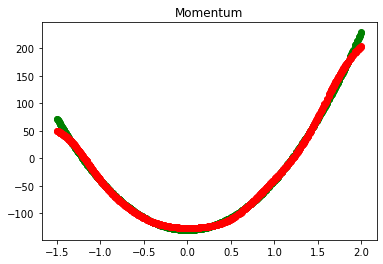

In [6]:
plt.scatter(X[0], y[0], color = "green")
plt.scatter(X[0], activations11[-1][0], color = 'red')
plt.title('Momentum')
plt.show()

In [7]:
mae11[-1]

3.016483294839327

### 1.2. RMSProp

In [8]:
mlp = MLP([1, 50,  1], activation_functions = ['sigmoid', 'linear'], initial_dist = 'gaussian')

mae12, activations12 = mlp.trainWithRMSProp(X, y, epochs = 100, batch_size = 10, eta = 0.1)

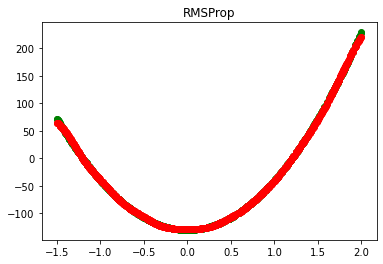

In [9]:
plt.scatter(X[0], y[0], color = "green")
plt.scatter(X[0], activations12[-1][0], color = 'red')
plt.title('RMSProp')
plt.show()

In [10]:
mae12[-1]

0.7755086555510732

### Results comparison

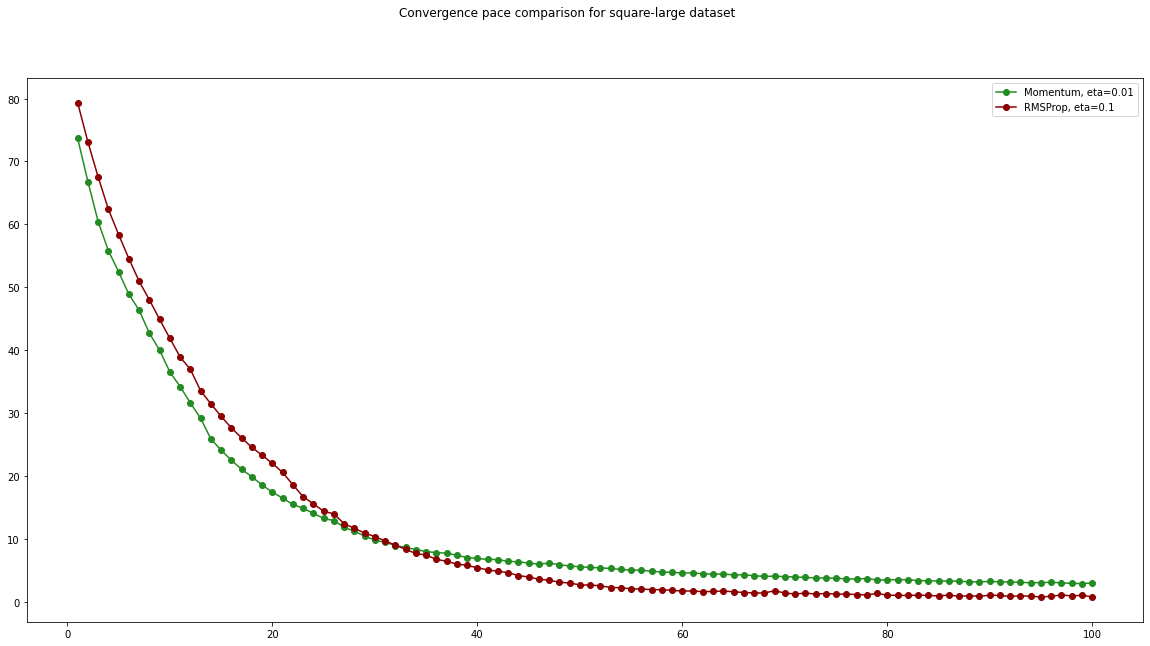

In [11]:
fig, ax = plt.subplots(figsize = (20, 10))
fig.suptitle('Convergence pace comparison for square-large dataset')
ax.plot(np.linspace(1, len(mae11), len(mae11)), mae11, '-o', color = 'forestgreen', label = 'Momentum, eta=0.01')
ax.plot(np.linspace(1, len(mae12), len(mae12)), mae12, '-o', color = 'darkred', label = 'RMSProp, eta=0.1')
ax.legend()

## 2. Steps-large dataset

In [12]:
train = pd.read_csv('../data/mio1/regression/steps-large-training.csv', index_col = 0)

X = train['x']
X = X.values.reshape(1,-1)
y = train['y']
y = y.values.reshape(1,-1)

### 2.1. Momentum

In [13]:
mlp = MLP([1, 5, 5,  1], activation_functions = ['sigmoid', 'sigmoid', 'linear'])

mae21, activations21 = mlp.trainWithMomentum(X, y, epochs = 100, batch_size = 10, eta = 0.0005)

Unrecognized initial distribution has been replaced with the default uniform distribution bounded with 0 and 1.


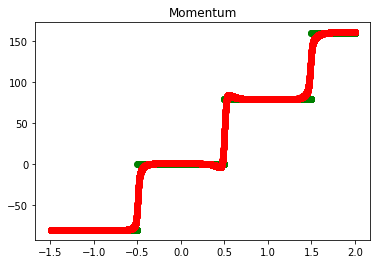

In [14]:
plt.scatter(X[0], y[0], color = "green")
plt.scatter(X[0], activations21[-1][0], color = 'red')
plt.title('Momentum')
plt.show()

In [15]:
mae21[-1]

1.9904295292563126

### 2.2. RMSProp

In [16]:
mlp = MLP([1, 5, 5,  1], activation_functions = ['sigmoid', 'sigmoid', 'linear'])

mae22, activations22 = mlp.trainWithRMSProp(X, y, epochs = 100, batch_size = 10, eta = 0.1)
z, activations = mlp.forward(X)

Unrecognized initial distribution has been replaced with the default uniform distribution bounded with 0 and 1.


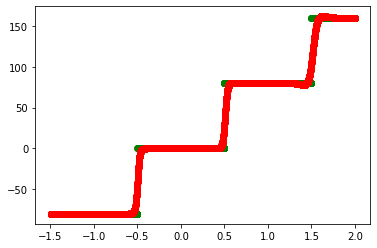

In [17]:
plt.scatter(X[0], y[0], color = "green")
plt.scatter(X[0], activations22[-1][0], color = 'red')
plt.show()

In [18]:
mae22[-1]

1.7351997726942059

### Results comparison

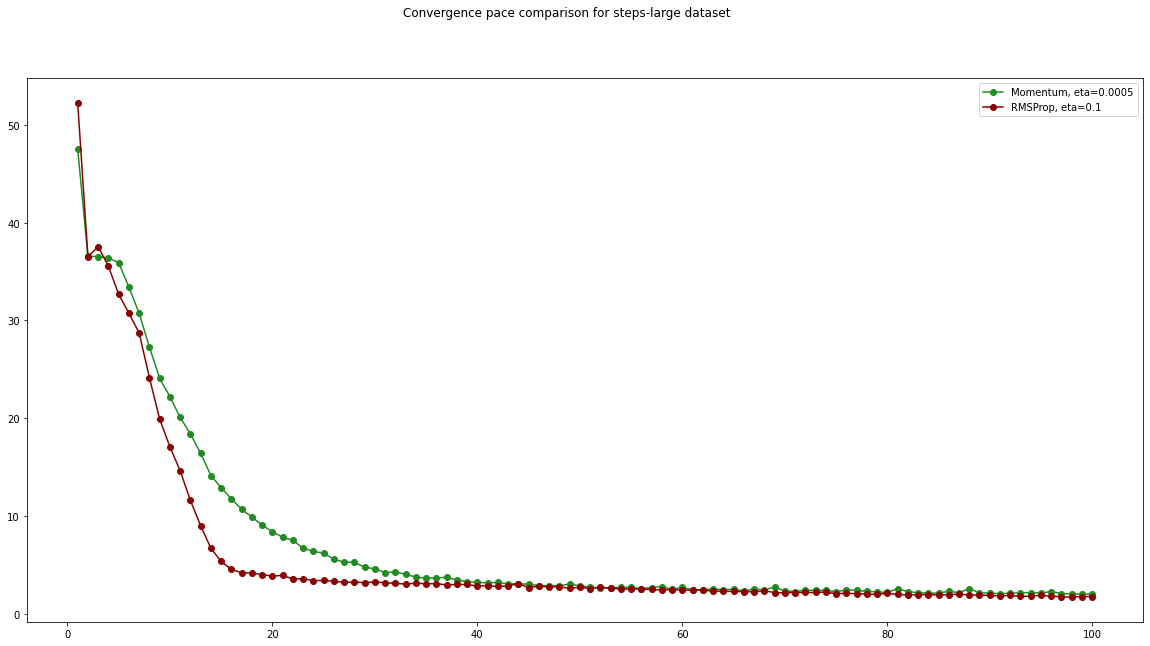

In [19]:
fig, ax = plt.subplots(figsize = (20, 10))
fig.suptitle('Convergence pace comparison for steps-large dataset')
ax.plot(np.linspace(1, len(mae21), len(mae21)), mae21, '-o', color = 'forestgreen', label = 'Momentum, eta=0.0005')
ax.plot(np.linspace(1, len(mae22), len(mae22)), mae22, '-o', color = 'darkred', label = 'RMSProp, eta=0.1')
ax.legend()

## 3. Multimodal-large dataset

In [20]:
train = pd.read_csv('../data/mio1/regression/multimodal-large-training.csv', index_col = 0)

X = train['x']
X = X.values.reshape(1,-1)
y = train['y']
y = y.values.reshape(1,-1)

### 3.1. Momentum

In [21]:
mlp = MLP([1, 5, 5, 1], activation_functions = ['sigmoid', 'sigmoid', 'linear'])

mae31, activations31 = mlp.trainWithMomentum(X, y, epochs = 100, batch_size = 10, eta = 0.0005)

Unrecognized initial distribution has been replaced with the default uniform distribution bounded with 0 and 1.


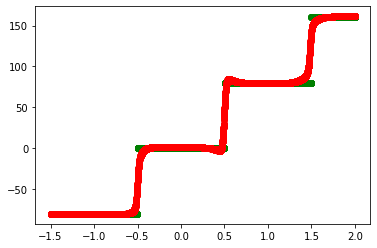

In [22]:
ax = plt.subplot()
plt.scatter(X[0], y[0], color = "green")
plt.scatter(X[0], activations31[-1][0], color = 'red')
plt.show()

In [23]:
mae31[-1]

2.0889820621284225

### 3.2. RMSProp

In [24]:
mlp = MLP([1, 5, 5, 1], activation_functions = ['sigmoid', 'sigmoid', 'linear'])

mae32, activations32 = mlp.trainWithRMSProp(X, y, epochs = 100, batch_size = 10, eta = 0.1)

Unrecognized initial distribution has been replaced with the default uniform distribution bounded with 0 and 1.


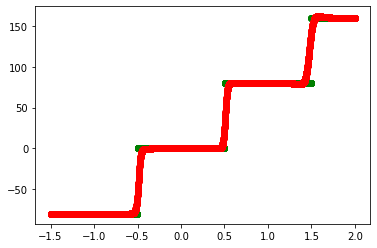

In [25]:
ax = plt.subplot()
plt.scatter(X[0], y[0], color = "green")
plt.scatter(X[0], activations32[-1][0], color = 'red')
plt.show()

In [26]:
mae32[-1]

1.7813460666911252

### Results comparison

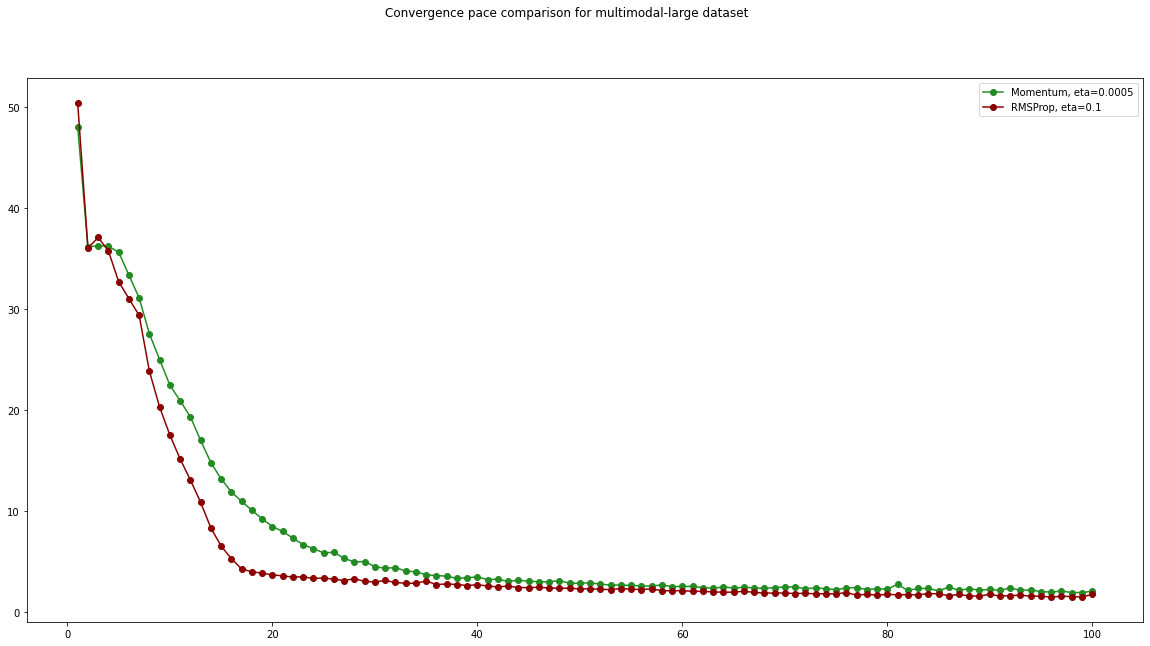

In [27]:
fig, ax = plt.subplots(figsize = (20, 10))
fig.suptitle('Convergence pace comparison for multimodal-large dataset')
ax.plot(np.linspace(1, len(mae31), len(mae31)), mae31, '-o', color = 'forestgreen', label = 'Momentum, eta=0.0005')
ax.plot(np.linspace(1, len(mae32), len(mae32)), mae32, '-o', color = 'darkred', label = 'RMSProp, eta=0.1')
ax.legend()